In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Chuẩn bị dữ liệu

In [9]:
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [10]:
data_dir = "../input/asl-alphabet/asl_alphabet_train/asl_alphabet_train"
input_size= (128, 128) # Các ảnh sẽ được resize về một kích thước chung, độ phân giải càng cao càng tốn tài nguyên (CPU, GPU, RAM,..)
val_frac = 0.1         # Tỉ lệ của tập validation sẽ được chia ra từ tập train, thường chia theo các tỉ lệ 9:1, 8:2, 7:3
batch_size = 128       # Số ảnh xử lý/lần để cập nhật tham số, số càng cao càng tốn tài nguyên

# Tiền xử lý dữ liệu ảnh để mô hình học tốt hơn
data_augmentor = ImageDataGenerator(samplewise_center=True,            # Chuẩn hoá mean của các giá trị pixel
                                    samplewise_std_normalization=True, # Chuẩn hoá khoảng giá trị của các pixel
                                    validation_split=val_frac)

# Đọc dữ liệu từ thư mục và tiền xử lý
train_generator = data_augmentor.flow_from_directory(data_dir, 
                                                     target_size=input_size, 
                                                     batch_size=batch_size, 
                                                     shuffle=True, 
                                                     subset="training")
val_generator = data_augmentor.flow_from_directory(data_dir, 
                                                   target_size=input_size, 
                                                   batch_size=batch_size, 
                                                   subset="validation")

Found 78300 images belonging to 29 classes.
Found 8700 images belonging to 29 classes.


In [11]:
# Có 29 lớp trong tập train, tương ứng với 29 folders
train_generator.class_indices

{'A': 0,
 'B': 1,
 'C': 2,
 'D': 3,
 'E': 4,
 'F': 5,
 'G': 6,
 'H': 7,
 'I': 8,
 'J': 9,
 'K': 10,
 'L': 11,
 'M': 12,
 'N': 13,
 'O': 14,
 'P': 15,
 'Q': 16,
 'R': 17,
 'S': 18,
 'T': 19,
 'U': 20,
 'V': 21,
 'W': 22,
 'X': 23,
 'Y': 24,
 'Z': 25,
 'del': 26,
 'nothing': 27,
 'space': 28}

In [12]:
len(train_generator.class_indices)

29

# Xây dựng mô hình

In [18]:
num_classes = len(train_generator.class_indices) # 29
input_shape = (128, 128, 3)                      # 3 chiều cho ảnh RGB

# Cấu trúc mô hình tham khảo
model = keras.models.Sequential([
    keras.Input(shape=input_shape),
    # block 1
    keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),     # Layer tích chập
    keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),     # Thêm Layer tích chập để học nhiều chi tiết hơn
    keras.layers.MaxPooling2D(pool_size=(2, 2)),                        # Layer MaxPool luôn theo sau layer Conv
    keras.layers.Dropout(0.5),                                          # Layer Dropout để mô hình không bị thiên kiến
    # block 2
    keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),     # Cấu trúc giống với block 1, tăng chiều từ 32 lên 64
    keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Dropout(0.5),
    # block 3
    keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),    # Cấu trúc giống với block 1, tăng chiều từ 64 lên 128
    keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),                         
    keras.layers.Dropout(0.5),
    # FCN block chịu trách nhiệm phân loại
    keras.layers.Flatten(),                                            # Chỉ có một layer flatten trong mô hình
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(num_classes, activation='softmax'),             # Layer Dense cuối có chiều là tổng số class
])
model.compile(optimizer='adam',                 # Luôn sử dụng `adam`
              loss='categorical_crossentropy',  # `binary_crossentropy` cho lớp True/False, `categorical_crossentropy` cho nhiều lớp
              metrics=["accuracy"])             # Đánh giá mô hình dựa trên độ chính xác
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 124, 124, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 60, 60, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 58, 58, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 29, 29, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 29, 29, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 27, 27, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 25, 25, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     2,359,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 29)             │         3,741 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,650,173 (10.11 MB)

 Trainable params: 2,650,173 (10.11 MB)

 Non-trainable params: 0 (0.00 B)

# Huấn luyện mô hình

In [14]:
model.fit(train_generator, 
          epochs=5, 
          validation_data=val_generator)

Epoch 1/5


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


612/612 ━━━━━━━━━━━━━━━━━━━━ 274s 429ms/step - accuracy: 0.1061 - loss: 3.1306 - val_accuracy: 0.4493 - val_loss: 1.7030
Epoch 2/5
612/612 ━━━━━━━━━━━━━━━━━━━━ 323s 525ms/step - accuracy: 0.3402 - loss: 1.9351 - val_accuracy: 0.6218 - val_loss: 1.1580
Epoch 3/5
612/612 ━━━━━━━━━━━━━━━━━━━━ 262s 423ms/step - accuracy: 0.4503 - loss: 1.5215 - val_accuracy: 0.6753 - val_loss: 0.9702
Epoch 4/5
612/612 ━━━━━━━━━━━━━━━━━━━━ 171s 277ms/step - accuracy: 0.5175 - loss: 1.3208 - val_accuracy: 0.7391 - val_loss: 0.7900
Epoch 5/5
612/612 ━━━━━━━━━━━━━━━━━━━━ 143s 231ms/step - accuracy: 0.5745 - loss: 1.1526 - val_accuracy: 0.7582 - val_loss: 0.7349


In [16]:
# Model được lưu sẽ nằm trong folder /kaggle/working/
model.save('model.keras')

## [Mở rộng] Huấn luyện có checkpoint

In [19]:
# Sử dụng class ModelCheckpoint của keras để hỗ trợ lưu mô hình
from tensorflow.keras.callbacks import ModelCheckpoint

In [20]:
checkpoint = ModelCheckpoint(
    filepath='model_epoch_{epoch:02d}.keras',  # Tên mẫu của file (v.d. checkpoint tại epoch 1 là `model_epoch_01.keras`)
    save_weights_only=False,                   # Lưu cả cấu trúc và thông số của mô hình
    save_best_only=False,                      # Set về True để chỉ lưu khi mô hình cải thiện
    monitor='val_loss',                        # Chọn thang đo để theo dõi mô hình (v.d. 'val_loss', 'val_accuracy')
    verbose=1                                  # Hiển thị thông tin ra màn hình khi mô hình được checkpoint
)

# Huấn luyện mô hình với config đã chọn
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=4,                            # Số lần train toàn bộ dữ liệu
    callbacks=[checkpoint]               # Thêm config checkpoint
)

Epoch 1/4
612/612 ━━━━━━━━━━━━━━━━━━━━ 0s 637ms/step - accuracy: 0.1844 - loss: 2.7806
Epoch 1: saving model to model_epoch_01.keras
612/612 ━━━━━━━━━━━━━━━━━━━━ 435s 685ms/step - accuracy: 0.1847 - loss: 2.7795 - val_accuracy: 0.6997 - val_loss: 0.9169
Epoch 2/4
612/612 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step - accuracy: 0.7083 - loss: 0.8365
Epoch 2: saving model to model_epoch_02.keras
612/612 ━━━━━━━━━━━━━━━━━━━━ 213s 343ms/step - accuracy: 0.7084 - loss: 0.8363 - val_accuracy: 0.8263 - val_loss: 0.4827
Epoch 3/4
612/612 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - accuracy: 0.8336 - loss: 0.4629
Epoch 3: saving model to model_epoch_03.keras
612/612 ━━━━━━━━━━━━━━━━━━━━ 207s 337ms/step - accuracy: 0.8336 - loss: 0.4628 - val_accuracy: 0.8597 - val_loss: 0.3998
Epoch 4/4
612/612 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - accuracy: 0.8827 - loss: 0.3296
Epoch 4: saving model to model_epoch_04.keras
612/612 ━━━━━━━━━━━━━━━━━━━━ 165s 267ms/step - accuracy: 0.8827 - loss: 0.3295 - val_accuracy: 0.8934 - v

# Dự đoán bằng mô hình

## Load mô hình

In [44]:
import numpy as np
from tensorflow.keras.saving import load_model

# Load model từ folder working
loaded_model = load_model('/kaggle/input/models/model_epoch_04.keras')

## Dự đoán trên một hình

In [23]:
import matplotlib.pyplot as plt
import cv2
from glob import glob

In [24]:
# Sử dụng hàm glob để đọc ảnh từ thư mục test (để biểu diễn)
test_images = glob('../input/asl-alphabet/asl_alphabet_test/asl_alphabet_test/**')
test_images[:5]

['../input/asl-alphabet/asl_alphabet_test/asl_alphabet_test/A_test.jpg',
 '../input/asl-alphabet/asl_alphabet_test/asl_alphabet_test/E_test.jpg',
 '../input/asl-alphabet/asl_alphabet_test/asl_alphabet_test/L_test.jpg',
 '../input/asl-alphabet/asl_alphabet_test/asl_alphabet_test/N_test.jpg',
 '../input/asl-alphabet/asl_alphabet_test/asl_alphabet_test/S_test.jpg']

In [25]:
# Tạo dictionary chứa index tương ứng với tên class
classes = train_generator.class_indices
classes = dict((v,k) for k,v in classes.items())
classes

{0: 'A',
 1: 'B',
 2: 'C',
 3: 'D',
 4: 'E',
 5: 'F',
 6: 'G',
 7: 'H',
 8: 'I',
 9: 'J',
 10: 'K',
 11: 'L',
 12: 'M',
 13: 'N',
 14: 'O',
 15: 'P',
 16: 'Q',
 17: 'R',
 18: 'S',
 19: 'T',
 20: 'U',
 21: 'V',
 22: 'W',
 23: 'X',
 24: 'Y',
 25: 'Z',
 26: 'del',
 27: 'nothing',
 28: 'space'}

Text(0.5, 1.0, 'N_test.jpg')

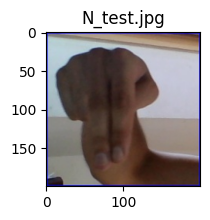

In [33]:
test_image_path = test_images[3]
im = cv2.imread(test_image_path)
plt.rcParams['figure.figsize'] = (2.0, 2.0)
plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
plt.title(test_image_path.split("/")[-1])

In [30]:
from tensorflow.keras.preprocessing import image

img = image.load_img(test_image_path, target_size=(input_size))  # Resize về (128, 128)
img_array = image.img_to_array(img)                              # Chuyển từ kiểu dữ liệu hình sang kiểu numpy array

img_array = np.expand_dims(img_array, axis=0)                    # Thêm chiều n=1, nghĩa là batch_size=1 => phù hợp cho việc dự đoán
test_datagen = ImageDataGenerator(                               # Bắt buộc áp dụng các phương pháp tiền xử lý như tập train
    samplewise_center=True,            
    samplewise_std_normalization=True
)
img_generator = test_datagen.flow(img_array, batch_size=1)       # Thay vì sử dụng `flow_from_directory` thì chỉ sử dụng `flow`

prediction = loaded_model.predict(next(img_generator))           # Sử dụng phương thức .predict()
prediction_label = np.argmax(prediction)
print("Prediction:", classes[prediction_label])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Prediction: N


## [Mở rộng] Dự đoán nhiều hình

In [45]:
# Tiền xử lý ảnh trong folder test
test_dir = "../input/asl-alphabet/asl_alphabet_test"   # Vì ảnh trong test không chia theo class nên lấy đường dẫn đến thư mục mẹ
test_generator = test_datagen.flow_from_directory(test_dir, 
                                                  target_size=input_size,
                                                  batch_size=1,
                                                  shuffle=None,
                                                  class_mode=None)

Found 28 images belonging to 1 classes.


In [46]:
# Thực hiện đánh giá trên tập test
preds = loaded_model.predict(test_generator, verbose=1)
preds = np.argmax(preds, axis=1)
preds_labels = [classes[pred] for pred in preds]
print(preds_labels)

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'nothing', 'space']
